
 #  Introduction

Baseball is one of the most popular sports in the US. More than 70 million people attend the games each season and much more follow their team's games online or on TV: almost one in two Americans claims to be a baseball fan.

The amount of data collected throughout the years makes baseball the indisputable king of statistics among all sports. Statistical analysis can make a distinction between facts and myths in baseball. No matter how obvious it appears at first sight, some of the concepts or ideas we are used to, are just wrong: the existence of clutch hitters or the home field advantage in final postseason games are some examples. At some point, it is not easy to know how many of our long lasting convictions remain valid after a closer look. 

Certain physical characteristics of the professional baseball players are tough to modify with training (i.e. weight, batting left or right-handed) while others are just impossible: (height, age, etc.). How do these characteristics relate to the individual batting performance? This is a question we decided to put to the test in this project.

Evaluating batting performance is not a simple task, and it has changed over the years [1]. 

The traditional way to measure the batting performance consists of three statistics: the batting average (AVG), runs batted in (RBI) and home runs (HR).

     AVG = H/AB  (1)       
were: H denotes the number of hits (including singles, doubles, triples and home runs) and AB is the number of at-bats.

Although these statistics remain decisive in awarding batting performance, there are several important facts they do not take into account:
AVG measures the ability to reach base, however producing a hit is not the only way to do so (base on balls (BB) and hit by pitch (HBP) also serve the same purpose). Also, this statistic makes no difference between a single and a homerun. 
RBI is a statistic that works perfect for teams but not so well for individuals. It accounts for the ability of the player to deliver when other team members are on base. The main drawback here is that the batter has no control over others being in scoring position when he steps in. A good hitter on a bad team could have less RBI than a less good hitter on a red-hot team, just because as an average the second hitter will encounter more team members on base each time he has an at-bat [2].
For reasons like those mentioned above, some other statistics were created to account for the missing points [3, 4]: 

-On-base percentage (OBP): OBP = (H + BB + HBP)/(AB + BB + HBP + SF) (2) 
where SF accounts for Sacrifice Fly

-Slugging Percentage (SLG): SLG = (1 x 1B + 2 x 2B + 3 x 3B + 4 x HR)/AB (3) 
where 1B = singles, 2B = doubles, 3B = triples

-Runs Created (RC):   RC = OBP x SLG x AB (4)

Eq (4) is the simplest formula for RC.  What is remarkable with this statistic is that if we take the sum of RC for all players in a team it nearly matches the total of runs scored by that team. Modern ways to account for RC in a more precise manner involve more statistics (i.e. SO, GIDP, IBB, etc.) that are available only after 1954; that would represent a significative trim in our timeline. Since we are not trying to predict collective outcomes from individual performances, we decided to stick with equation (4). It is worth mentioning that we also used a more complex equation (results not included in this project) and the shape is similar to the one we obtained in this work for the given timeframe (just a little more 'flat' and lower in absolute value). 

In this project we used a slight variation of RC:

RC100 = RC/100 (5)

This one only differs from RC in absolute value and the conversion between the two is straightforward. We have redefined it just for visualization purposes.

OBP, SLG, and RC100 are the statistics we will use to account for the individual offensive performance throughout this project. 

#  Dataset:
Data downloaded from http://www.seanlahman.com/baseball-archive/statistics/ 
Specifically: 2015 – comma-delimited version – Updated March 2, 2016

#  Analyzing the data:
As physical factors for this project we choose:
Independent Variables: bats (R, L or B), weight and age.

Batting performance were analyzed using three statistics:
Dependent Variables: OBP, SLG, RC100

Whenever Statistics tests were applied, a significance level of 0.1% was used.

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns
from scipy import stats
from ipywidgets import *
import itertools
from scipy.interpolate import *
import matplotlib.ticker as ticker

In [2]:
filename0 = 'baseball/core/Batting.csv'
batting_df = pd.read_csv(filename0)
filename1 = 'baseball/core/Master.csv'
master_df = pd.read_csv(filename1)
filename2 = 'baseball/core/Pitching.csv'
pitching_df = pd.read_csv(filename2)

# Handling the data:

Even though we are working with a well-curated database, there are always some missing entries, mainly due to changes in the way statistics were collected in the past, or new statistics that appeared at some point in history, etc. 
Our approach towards the missing entries we undoubtedly will encounter is replacing the 'NaN' entries with some meaningful values whenever possible. Unfortunately, this could be accomplished in a small number of cases. For the rest of the missing entries, the only viable solution is to exclude the entire row from the analysis.

We are going to perform the cleaning process at to different levels. First: We are going to do a 'general' searching and cleaning procedure focused in the entries we will need in all cases, such as AB, H, HR, SF, etc. We will also include new columns related to the statistics we are going to use as dependent variables.

Second: Starting from the already cleaned DataFrame, we are going to analyze the entries we need to work with a particular variable, at the time we need it. 

According to the exploration performed in our data, (and confirmed later with an online search), there is no records in the sacrifice fly (SF) column before 1954. We decided to make SF = 0 for all the missing entries in agreement with a suggestion found elsewhere [5].
We discarded hitters with less than ten at-bats and 16 games played (10% of regular season games approx.), in this way we reduce the high variability in performance due to players that did not play regularly.

In the case of other missing entries (such us weight, or HBP)  we decided to delete the corresponding rows. That represents in all cases a small amount of data compared to the size of our DataFrame.
We detected just a case of typing errors in database entries, and we corrected it.

In [3]:
# Exploring batting_df
# Checking for Null entries on certain columns
missing_stat01 = batting_df[pd.isnull(batting_df[['AB', 'H', '2B', '3B', 'HR']]).any(axis=1)].copy()
print 'Missing AB, H, 2B, 3B or HR: ', missing_stat01.playerID.count()

Missing AB, H, 2B, 3B or HR:  5149


In [4]:
# Are those players pitchers?
what = missing_stat01[~missing_stat01['playerID'].isin(pitching_df['playerID'])]
print 'There are', len(what), 'players in missing_stat01 that are not pitchers'

There are 0 players in missing_stat01 that are not pitchers


In [5]:
# Deleting the missing batting records for pitchers
batting_slice01 = batting_df[~batting_df['playerID'].isin(missing_stat01['playerID'])].copy()

In [6]:
# Checking out the rest of the columns we need for OBP, SLG and RC100 batting stats
missing_stat02 = batting_slice01[pd.isnull(batting_slice01[['SF']]).any(axis=1)]
print 'Missing BB, HBP or SF: ', missing_stat02.playerID.count()

#missing_stat02.groupby('yearID').count()


Missing BB, HBP or SF:  36032


In [7]:
# Before 1954 sacrifice flies were not counted as an official statistic. They were counted as sacrifice hits (SH), 
# which included both sacrifice flies and bunts. As bounting is an offensive strategy, dictated by managers most 
# of the time, we are not going to use SH here. We are going to fill those missing values with 
# zeroes instead.

batting_slice01['SF']= batting_slice01['SF'].fillna(0)
#batting_slice01

In [8]:
missing_stat03 = batting_slice01[pd.isnull(batting_slice01[['BB', 'HBP']]).any(axis=1)]
print 'Missing BB, HBP or SF: ', missing_stat03.playerID.count()

#missing_stat03.groupby('yearID').count()

Missing BB, HBP or SF:  2810


In [9]:
# Excluding entries without HBP 
batting_slice02 = batting_slice01[batting_slice01['HBP'].notnull()].copy()


In [10]:
# Ruling out hitters with less than 10 AB and less than 16 Games (10% of the games in a regular season).
working_bat_df = batting_slice02[(batting_slice02['AB']> 10) & (batting_slice02['G']> 16)].copy()

In [11]:
# Batting data is now clean.
working_bat_df[pd.isnull(working_bat_df[['AB', 'H','2B','3B', 'HR','BB', 'HBP', 'SF']]).any(axis=1)]

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP


In [12]:
# The column 'H' includes not only singles, but also 2B, 3B and HR as well. It implies adjustments in SLG formula
def ave(x):
    return x['H']/x['AB']
def slg(x):
    return (x['H'] + x['2B'] + 2*x['3B'] + 3*x['HR'] )/x['AB']
def obp(x):
    return (x['H'] + x['BB'] + x['HBP'])/(x['AB'] + x['BB'] + x['HBP'] + x['SF'])
def rc100(x):
    return (x['AB'] * x['SLG'] * x['OBP'])/100.0
def ops(x):
    return x['SLG'] + x['OBP']

In [13]:
# Adding new columns to the working dataframe that account for the new statistics we want to study

working_bat_df['AVG'] = working_bat_df.apply(ave, axis = 1)
working_bat_df['SLG'] = working_bat_df.apply(slg, axis = 1)
working_bat_df['OBP'] = working_bat_df.apply(obp, axis = 1)
working_bat_df['OPS'] = working_bat_df.apply(ops, axis = 1)
working_bat_df['RC100'] = working_bat_df.apply(rc100, axis = 1)

In [14]:
# Merging with the master in order to obtain all the info we need to work with our independent vars

batting_merged = working_bat_df.merge(master_df, on = 'playerID', how = 'inner')

print len(working_bat_df)==len(batting_merged)
print 'batting_merged: ', len(batting_merged)

True
batting_merged:  54937


In [15]:
#How many entries before 1880? 
len(batting_merged[batting_merged['yearID']< 1880])

1

In [16]:
# Is not worth keeping it
batting_merged = batting_merged[batting_merged['yearID']>= 1880]

At this point, we finished the first stage in the data cleaning process. 
batting_merged is now our initial working DataFrame for every independent variable.

# The difference of batting right-handed, left-handed or switch:

In [17]:
# Batting position (L, R, B)
missing_stat05 = batting_merged[(pd.isnull(batting_merged[['bats']]).any(axis=1))]
print 'missing stat05', len(missing_stat05)
bat_hand01 = batting_merged[(batting_merged['bats'].notnull())]

missing stat05 319


In [18]:
len(bat_hand01)==len(batting_merged)-len(missing_stat05)

True

In [19]:
right_bat = bat_hand01[bat_hand01['bats']=='R']
left_bat = bat_hand01[bat_hand01['bats']=='L']
switch_bat = bat_hand01[bat_hand01['bats']=='B']

In [20]:
# Searching for different players 
unique_r_bat =bat_hand01[bat_hand01['bats']=='R'].groupby('playerID').count().reset_index()
print 'R:', unique_r_bat.playerID.count()
unique_l_bat =bat_hand01[bat_hand01['bats']=='L'].groupby('playerID').count().reset_index()
print 'L:', unique_l_bat.playerID.count()
unique_s_bat =bat_hand01[bat_hand01['bats']=='B'].groupby('playerID').count().reset_index()
print 'S:', unique_s_bat.playerID.count()
print 'Total:', unique_r_bat.playerID.count()+unique_l_bat.playerID.count()+unique_s_bat.playerID.count()

R: 6091
L: 2809
S: 797
Total: 9697


Figure 1. Percent Distribution of Hitters


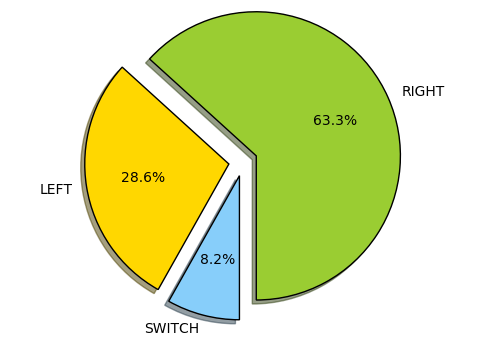

In [21]:
# Making a simple pie plot

all_players = unique_r_bat.playerID.count()+unique_l_bat.playerID.count()+unique_s_bat.playerID.count()
r_percent = 100*unique_r_bat.playerID.count()/all_players
l_percent = 100*unique_l_bat.playerID.count()/all_players
s_percent = 100*unique_s_bat.playerID.count()/all_players

p_list = np.array([r_percent, l_percent, s_percent])
labels = np.array(['RIGHT', 'LEFT', 'SWITCH'])
colors = np.array(['yellowgreen', 'gold', 'lightskyblue'])
explode = (0.1, 0.1, 0.1) 
plt.pie(p_list, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=270)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')


print 'Figure 1. Percent Distribution of Hitters' 

The pie plot in figure 1 displays the percent distribution of the hitters by the side they swing their bats. In our sample, over 63% of the 9697 players bats right-handed; approximately 29% are hitting from the left, and under 9% of them are switch hitters. Near one in three baseball players are left-handers, in spite that they represent only 10% of the overall population and could not play half of the defensive positions (3B, 2B, SS, and catcher are right-handed player spots). At this point, we can only think that baseball has to be very attractive to left-handed players.

Figure 2. Mean values of OBP, SLG, and RC100 split by Left (L), Right (R) or Switch (B)


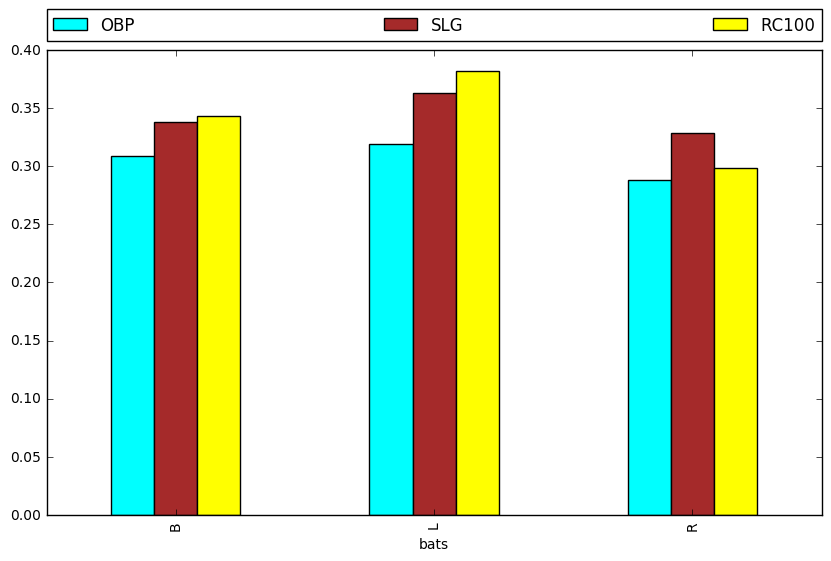

In [22]:
bat_grouped_by_hand = bat_hand01.groupby('bats').mean()
colors = ['cyan', 'brown', 'yellow']
bat_grouped_by_hand[['OBP', 'SLG', 'RC100']].plot(kind = 'bar', figsize = (10,6), color = colors)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=3, mode="expand", borderaxespad=0.)
print 'Figure 2. Mean values of OBP, SLG, and RC100 split by Left (L), Right (R) or Switch (B)'

Figure 2 displays mean values of OBP, SLG and RC100 split across left (L), right (R) and switch (B) hitters. Their corresponding numerical values are presented in Table 1.  Left-handed hitters show superior performance in all three categories, followed by switch hitters and right-handed hitters, in that order.

In [23]:
# Creating a table to display numerical mean values

rc100_league = bat_hand01['RC100'].mean()
obp_league = bat_hand01['OBP'].mean()
slg_league = bat_hand01['SLG'].mean()

l_obp = round(left_bat['OBP'].mean(),3)
r_obp = round(right_bat['OBP'].mean(),3)
s_obp = round(switch_bat['OBP'].mean(),3)

l_slg = round(left_bat['SLG'].mean(),3)
r_slg = round(right_bat['SLG'].mean(),3)
s_slg = round(switch_bat['SLG'].mean(),3)

l_rc100 = round(left_bat['RC100'].mean(),3)
r_rc100 = round(right_bat['RC100'].mean(),3)
s_rc100 = round(switch_bat['RC100'].mean(),3)

obp_all = round(obp_league,3)
slg_all = round(slg_league,3)
rc100_all = round(rc100_league,3)


bat_df = pd.DataFrame({'OBP': [l_obp, r_obp, s_obp, obp_all],'SLG': [l_slg, r_slg, s_slg, slg_all]
                           , 'RC100': [l_rc100, r_rc100, s_rc100, rc100_all]}
                          , index = ['L', 'R', 'B', 'LEAGUE'])



print 'Table 1: Mean values of OBP, SLG, and RC100 split into Left, Right, and Switch'
bat_df

Table 1: Mean values of OBP, SLG, and RC100 split into Left, Right, and Switch


,OBP,RC100,SLG
L,0.319,0.382,0.363
R,0.288,0.298,0.328
B,0.309,0.343,0.338
LEAGUE,0.299,0.328,0.340


Those results could be explained to some extent by the fact that left-handed hitters enjoy certain 'small' advantages over right-handed players: 

- They stand at the plate a couple of steps closer to the first base (myth, debunked in [6]) 
- Left-handed hitters face mostly right-handed pitchers. The way in wich pitchers delivers the ball, favors a better view from the opposite side of the plate.
- There is a still a less apparent reason, explained in ref[6] as positional bias. 

As we mentioned before, certain defensive positions are open just to right-handed players,  three of them are premium defensive positions. Teams usually prefer an outstanding defensive player at SS, 2B and catcher even if it means a reduced offensive production.  

In [24]:
grouped_by_hand = bat_hand01.groupby('bats') 
bat_hand = ['B', 'L', 'R']

In [25]:
def indep_ttest_groups(grouped_data, var):
    '''This function performs independent t-tests on samples when combinations are required. Grouped_data is of 
       the form DataFram.groupby and var is a list. The output is a DataFrame that contains tuples
       of the form (t, p), where t is the statistic and p is probability.
    '''
    d = {}
   
    for ituple in list(itertools.combinations(range(len(var)),2)):
        
        d[str(var[ituple[0]]+'-'+var[ituple[1]])] = {}
        d[str(var[ituple[0]]+'-'+var[ituple[1]])]['OBP'] = stats.ttest_ind(grouped_data.get_group(var[ituple[0]])
                                .OBP, grouped_data.get_group(var[ituple[1]]).OBP)
        
        d[str(var[ituple[0]]+'-'+var[ituple[1]])]['SLG'] = stats.ttest_ind(grouped_data.get_group(var[ituple[0]])
                                .SLG, grouped_data.get_group(var[ituple[1]]).SLG)
        
        d[str(var[ituple[0]]+'-'+var[ituple[1]])]['RC100'] = stats.ttest_ind(grouped_data.get_group(var[ituple[0]])
                                .RC100, grouped_data.get_group(var[ituple[1]]).RC100)
    
    return pd.DataFrame(d).T

We conducted a series of independent t-tests to find out if the differences found in the dependent variables are caused just by chance.

Null Hypothesis 1X: mean_switch_x = mean_left_x,  
Alternate Hypothesis 1: mean_switch_x != mean_left_x,

Null Hypothesis 2X: mean_switch_x = mean_rigth_x, 
Alternate Hypothesis 2: mean_switch_x != mean_rigth_x, 

Null Hypothesis 3X: mean_left_x = mean_rigth_x, 
Alternate Hypothesis 3: mean_left_x != mean_rigth_x,

Where x accounts for: OBP, SLG, and RC100. Then we have in fact 9 t-tests to perform. The results are shown in Table 2. All null hypotheses were rejected, so we can state with a high degree of confidence that those results are extremely unlikely to happen just by chance. 


In [26]:
print 'Table 2. Independent t-test for different batting hand combinations'
indep_ttest_groups(grouped_by_hand, bat_hand)

Table 2. Independent t-test for different batting hand combinations


,OBP,RC100,SLG
B-L,"(-9.04878566436, 1.56543124364e-19)","(-7.10879705319, 1.20718813756e-12)","(-14.2099060566, 1.2794476977e-45)"
B-R,"(18.6537623998, 2.59785622209e-77)","(9.49233062769, 2.38507414834e-21)","(5.7670453024, 8.12937890127e-09)"
L-R,"(43.6067187293, 0.0)","(26.7236404429, 3.23150294043e-156)","(31.3452406043, 1.40388832028e-213)"


As an average, left-handed hitters are the best offensive performers, and there are not clear arguments to explain why. The most common explanations were given above. Those reasons could explain somehow the difference between right-handed and left-handed hitters but certainly not the difference between left-handed and switch hitters. 

Could these differences be erased at some point in history with more and better training, or is this an intrinsic, fundamental difference in baseball?

To answer this question, at least in part, we created a plot of all three statistics averaged over each decade, from the 1880s up to the 2010s (just six years of stats in that one) and the results are displayed in figure 3. We observed how the gap between the three different kinds of hitters has been narrowing since the 1960s in all three statistics. We just can imagine that having access to more and better statistics, as well as to all the technological developments applied to baseball training have been slowly changing the landscape of hitting. If that difference could be erased or not is a question for generations ahead. For the moment, it seems that these differences have been decreasing. 

Figure 3. Time evolution of offensive statistics split into L, R, and B


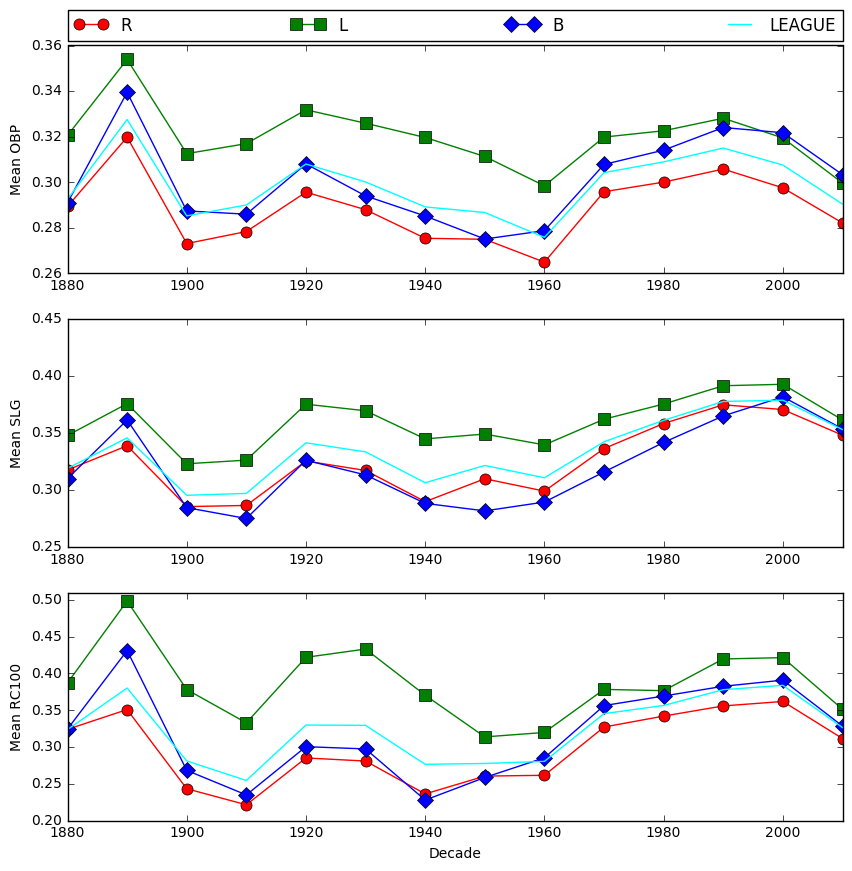

In [27]:
# How the difference among batters have evolved over time?
mean_by_dec = working_bat_df.groupby([(working_bat_df['yearID']//10)*10]).mean()

r_mean_by_dec = right_bat.groupby([(right_bat['yearID']//10)*10]).mean()
l_mean_by_dec = left_bat.groupby([(left_bat['yearID']//10)*10]).mean()
s_mean_by_dec = switch_bat.groupby([(switch_bat['yearID']//10)*10]).mean()

plt.figure(figsize = (10, 10))

plt.subplot(3,1,1)
r_mean_by_dec['OBP'].plot(c = 'r', label = 'R', marker='o', markersize= 8)
l_mean_by_dec['OBP'].plot(c = 'g', label = 'L', marker='s', markersize= 8)
s_mean_by_dec['OBP'].plot(c = 'b', label = 'B', marker='D', markersize= 8)
mean_by_dec['OBP'].plot(c = 'cyan', label = 'LEAGUE')
plt.xlabel('')
plt.ylabel('Mean OBP')
plt.xlim(1880, 2010)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=4, mode="expand", borderaxespad=0.)

plt.subplot(3,1,2)
r_mean_by_dec['SLG'].plot(c = 'r', label = 'R', marker='o', markersize= 8)
l_mean_by_dec['SLG'].plot(c = 'g', label = 'L', marker='s', markersize= 8)
s_mean_by_dec['SLG'].plot(c = 'b', label = 'B', marker='D', markersize= 8)
mean_by_dec['SLG'].plot(c = 'cyan', label = 'LEAGUE')
plt.xlabel('')
plt.ylabel('Mean SLG')
plt.xlim(1880, 2010)
plt.ylim(0.25, 0.45)


plt.subplot(3,1,3)
r_mean_by_dec['RC100'].plot(c = 'r', label = 'R', marker='o', markersize= 8)
l_mean_by_dec['RC100'].plot(c = 'g', label = 'L', marker='s', markersize= 8)
s_mean_by_dec['RC100'].plot(c = 'b', label = 'B', marker='D', markersize= 8)
mean_by_dec['RC100'].plot(c = 'cyan', label = 'LEAGUE')
plt.xlim(1880, 2010)
plt.ylim(0.20, 0.51)
plt.xlabel('Decade')
plt.ylabel('Mean RC100')

print 'Figure 3. Time evolution of offensive statistics split into L, R, and B'

# The weight factor.

In [28]:
# Weight
# Cleaning the data
bat_weight = batting_merged[(batting_merged['weight'].notnull())]

In figure 4 we can see a histogram of weight for hitters, it shows a bell-shaped behavior with a little tail toward heavier weights. The weight of hitters is spread into the [125,  295] lb interval, with the mean at 184.7 lb and the median at 182.0 lb.

Figure 4. Histogram of the distribution of weight


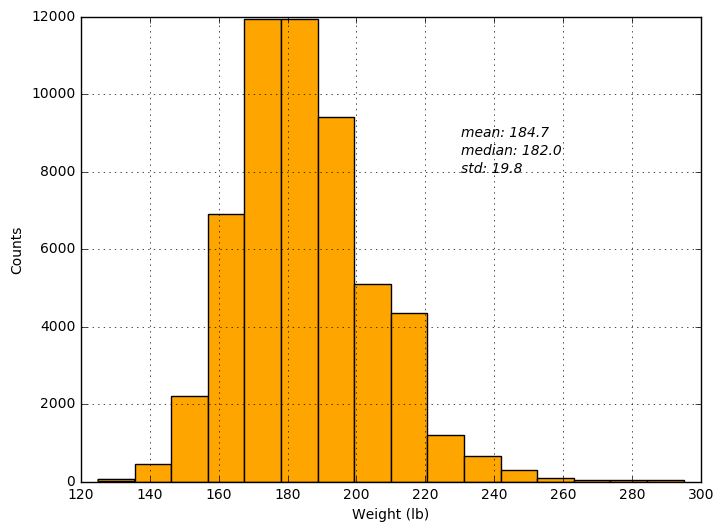

In [29]:
bat_weight['weight'].hist(bins = 16, color = 'orange', figsize = (8, 6))
plt.xlabel('Weight (lb)')
plt.ylabel('Counts')
mean_val = 'mean: ' + str(round(bat_weight['weight'].describe()[1], 1))
std_dev = 'std: ' + str(round(bat_weight['weight'].describe()[2], 1))
median = 'median: ' + str(round(bat_weight['weight'].describe()[5], 1))
plt.figtext(0.6, 0.7, mean_val, style='italic')
plt.figtext(0.6, 0.67, median, style='italic')
plt.figtext(0.6, 0.64, std_dev, style='italic')

print 'Figure 4. Histogram of the distribution of weight'

In [30]:
bat_weight['weight'].describe()

count    54700.000000
mean       184.708007
std         19.803550
min        125.000000
25%        170.000000
50%        182.000000
75%        195.000000
max        295.000000
Name: weight, dtype: float64

Figure 5. Mean values of OBP, SLG, RC100 split by weight quartile


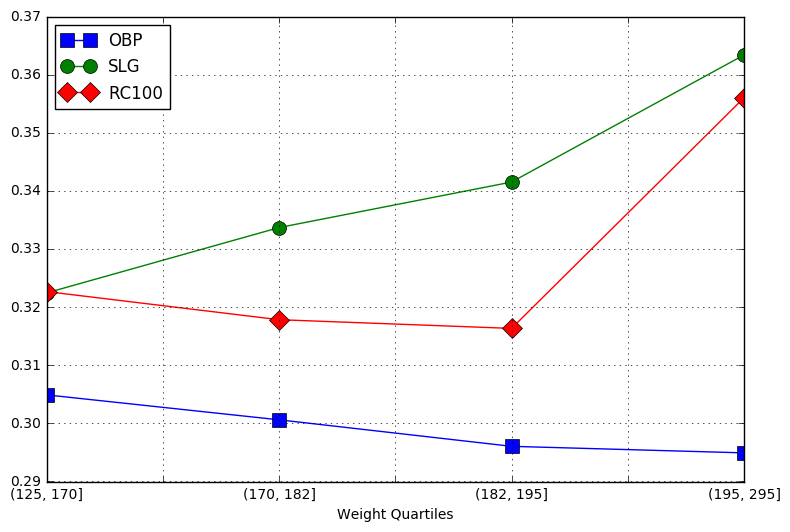

In [31]:
w_per = np.percentile(bat_weight['weight'], np.arange(0, 125, 25))
weight_quar = bat_weight.groupby(pd.cut(bat_weight['weight'], w_per)).mean()

weight_quar['OBP'].plot(figsize=(9,6), grid = True, marker='s', markersize= 10)
weight_quar['SLG'].plot(figsize=(9,6), grid = True, marker='o', markersize= 10)
weight_quar['RC100'].plot(figsize=(9,6), grid = True, marker='D', markersize= 10)
plt.legend(loc = 0)
plt.xlabel('Weight Quartiles')

print 'Figure 5. Mean values of OBP, SLG, RC100 split by weight quartile'
plt.show()

We used the information provided by descriptive statistics to split weight into four groups, one for each weight quartile (Q1: 125-170, Q2: 170-182, Q3: 182-195, Q4: 195-295), then we computed the mean values for our three offensive stats and displayed them in figure 5. Mean values of SLG increases consistently from Q1 up to Q4. Mean values of OBP decreases from Q1 up to Q3 then settles. Finally, RC100 remains almost constant from Q1 to Q3, then increases substantially. 

In our data, there is just one value of weight for each player. As a consequence, the dataset corresponding to each weight quartile is independent of the others.  We conducted a series of independent samples t-tests to find out whether or not the differences we saw are statistically significant.

 Null Hypothesis 1X,Y: mean_OBP_x = mean_OBP_y,  
Alternate Hypothesis 1: mean_OBP_x != mean_OBP_y,

Null Hypothesis 2X,Y: mean_SLG_x = mean_SLG_y, 
Alternate Hypothesis 2: mean_SLG_x != mean_SLG_y, 

Null Hypothesis 3X,Y: mean_RC100_x = mean_RC100_y, 
Alternate Hypothesis 3: mean_RC100_x != mean_RC100_y,

Now x, y account for all possible combinations of two different quartiles ( 6 in total), then we have to look at 18 different t-test results.

Table 3 shows the outcome of such t-tests. They confirm that the changes in mean SLG values are significant in all cases. For mean OBP values, their differences are significant except for Q3-Q4, where we could not reject the null hypothesis.  The differences in mean RC100 values are not significant for Q1-Q3 but are statistically significant for all combinations involving Q4.

In [32]:
weight_grouped = batting_merged.groupby(pd.cut(batting_merged['weight'], w_per))
weight_list = [weight_quar.index[0], weight_quar.index[1], weight_quar.index[2], weight_quar.index[3]]

print 'Table 3. Independent t-test for different weight quartiles'
indep_ttest_groups(weight_grouped, weight_list)

Table 3. Independent t-test for different weight quartiles


,OBP,RC100,SLG
"(125, 170]-(170, 182]","(5.12668554606, 2.96891319743e-07)","(1.29839867279, 0.194161304902)","(-9.17774815834, 4.70299479895e-20)"
"(125, 170]-(182, 195]","(10.628164537, 2.45813474735e-26)","(1.72809502449, 0.083981590643)","(-15.3169720596, 9.37783076942e-53)"
"(125, 170]-(195, 295]","(11.2790113843, 1.93798507539e-29)","(-8.2980273729, 1.10718681674e-16)","(-29.883986255, 4.32651068046e-193)"
"(170, 182]-(182, 195]","(5.0775234425, 3.84872908031e-07)","(0.378211742776, 0.705276213736)","(-5.67637322213, 1.3896042375e-08)"
"(170, 182]-(195, 295]","(5.96122830907, 2.53705836722e-09)","(-8.79897077954, 1.46814687486e-18)","(-19.565044351, 1.32022075344e-84)"
"(182, 195]-(195, 295]","(1.19331137469, 0.232757826279)","(-9.36483543426, 8.18492048345e-21)","(-14.4622078061, 3.14042433013e-47)"


The results seem to support our intuitive thoughts in relation that there is a connection between weight groups and average SLG. It appears that in the case of the mean OBP,  there is a decrease for groups of weight in the 125-195 lb range. Then the mean OBP stops decreasing for heavier players. Our guess is that maybe that has to do among others, with the average speed of the players. For example, a small increase in time when running from home to first base could make a difference between a single or an out up to certain point, beyond that it is going to be out if there are no fielding errors involved. Interestingly, RC100 combine both statistics, for that reason, it is not a surprise that for the first three quartiles, it remains constant (the differences in mean values are not statistically significant) as OBP and SLG trends cancel each other out. Then SLG keeps increasing while OBP stops decreasing, and as a consequence RC100 rises from Q3 to Q4.
RC is related to the contribution of individuals to the team's success. Apparently, the heavier group of baseball players are associated with higher values of RC100. 

Figure 6.Plots of Mean SLG, OBP, and RC100 vs. weight


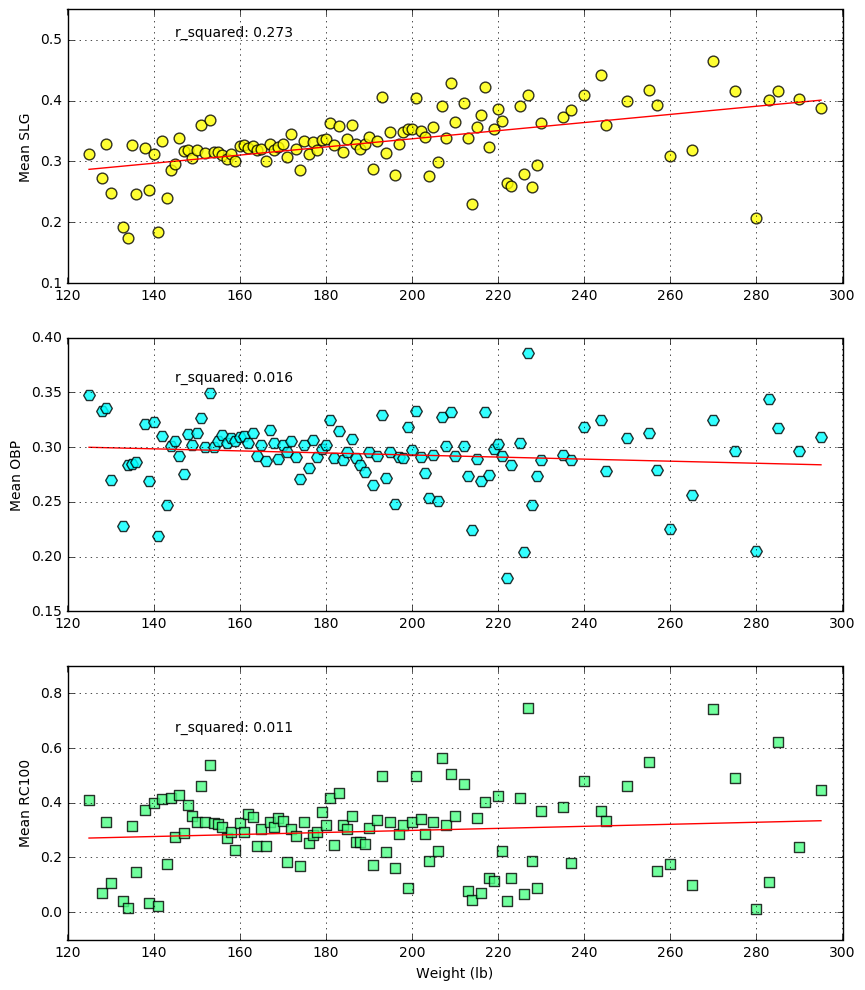

In [33]:
grouped_by_weight = bat_weight.groupby('weight', as_index=False)

plt.figure(figsize = (10,12))
mean_by_weight = grouped_by_weight.mean()

plt.subplot(3,1,1)
grouped_by_weight = batting_merged.groupby('weight', as_index=False)

x = mean_by_weight.weight
y = mean_by_weight.SLG
p1 = np.polyfit(x, y, 1)
plt.scatter(x, y, marker='o', c = 'yellow', s = 60, alpha = 0.8)
plt.plot(x, np.polyval(p1,x), 'r-')
plt.xlim(120, 300)
plt.ylabel('Mean SLG')
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
r_sqr = 'r_squared: '+str(round(r_value**2, 3))
plt.text(145, .505, r_sqr)
plt.grid(True)

plt.subplot(3,1,2)

y = mean_by_weight.OBP
p1 = np.polyfit(x, y, 1)
plt.scatter(x, y, marker='H', c = 'cyan', s = 70, alpha = 0.8)
plt.plot(x, np.polyval(p1,x), 'r-')
plt.xlim(120, 300)
plt.ylim(0.15, 0.40)
#plt.xlabel('Weight (lb)')
plt.ylabel('Mean OBP')
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
r_sqr = 'r_squared: '+str(round(r_value**2, 3))
plt.text(145, .360, r_sqr)
plt.grid(True)

plt.subplot(3,1,3)

y = mean_by_weight.RC100
p1 = np.polyfit(x, y, 1)
plt.scatter(x, y, marker='s', c = '#4dff85', s = 60, alpha = 0.8)
plt.plot(x, np.polyval(p1,x), 'r-')
plt.xlim(120, 300)
plt.xlabel('Weight (lb)')
plt.ylabel('Mean RC100')
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
r_sqr = 'r_squared: '+str(round(r_value**2, 3))
plt.text(145, .660, r_sqr)
plt.grid(True)

print 'Figure 6.Plots of Mean SLG, OBP, and RC100 vs. weight'

In figure 6 we made scatter plots of mean values (SLG, OBP, and RC100) as a function of weight. The correlation among those statistics and weight are expressed through Pearson's r squared. The correlation between mean OBP, RC100 values and weight are near zero, and it is weak (r-squared = 0.27) for mean SLG values. However, it jumped up to 0.639 by excluding players with less than 200 AB (players that make the lineup for almost every game average more than 500 AB in a regular season). For a more consistent group of talented hitters, we can explain up to 64% of the variability in mean SLG values by the variability in weight(Figure 7). 

Figure 7. Mean SLG vs. weight for players with AB > 200


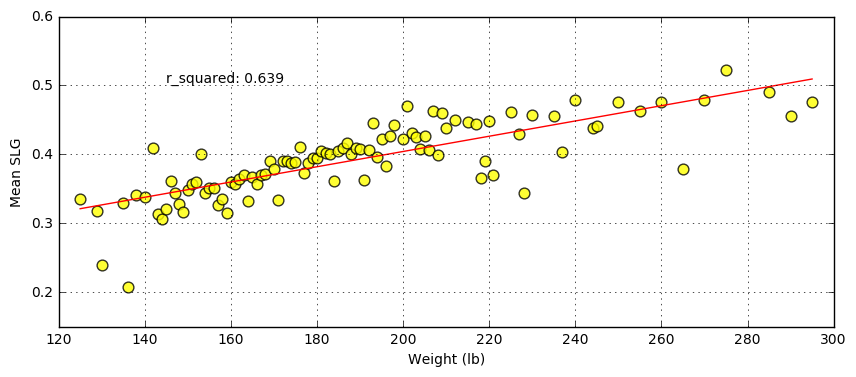

In [34]:
# Selecting players with more AB.

bat_weight_limited = bat_weight[bat_weight['AB']>= 200]
grouped_by_weight = bat_weight_limited.groupby('weight', as_index=False)

plt.figure(figsize = (10,4))
mean_by_weight = grouped_by_weight.mean()

grouped_by_weight = batting_merged.groupby('weight', as_index=False)

x = mean_by_weight.weight
y = mean_by_weight.SLG
p1 = np.polyfit(x, y, 1)
plt.scatter(x, y, marker='o', c = 'yellow', s = 60, alpha = 0.8)
plt.plot(x, np.polyval(p1,x), 'r-')
plt.xlim(120, 300)
plt.xlabel('Weight (lb)')
plt.ylabel('Mean SLG')
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
r_sqr = 'r_squared: '+str(round(r_value**2, 3))
plt.text(145, .505, r_sqr)
plt.grid(True)

print 'Figure 7. Mean SLG vs. weight for players with AB > 200'

Figures 5 and 7 sound like an invitation for heavier men to join the game, and it seems like it is what is happening lately, as depicted in figure 8. According to the data, a sharp increase in mean body weight has occurred over the last 30 years in Mayor League Baseball.

Figure 8. Mean Weight split by decade


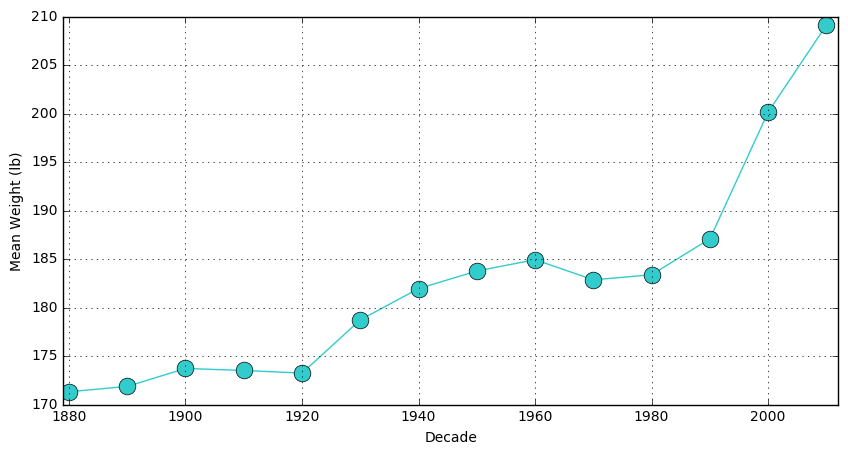

In [52]:
mean_by_dec02 = bat_weight.groupby([(bat_weight['yearID']//10)*10]).mean()
mean_by_dec02['weight'].plot(figsize = (10,5), marker='o', markersize= 12, grid = True, color = '#33cccc')
plt.ylabel('Mean Weight (lb)')
plt.xlabel('Decade')
plt.xlim(1879, 2012)
print 'Figure 8. Mean Weight split by decade'

# The age factor

In [36]:
# Age
#batting_merged.keys()
missing_stat07 = batting_merged[(pd.isnull(batting_merged[['yearID', 'birthYear']]).any(axis=1))]
#len(missing_stat07[['yearID', 'birthYear']])

In [37]:
# Cleaning the data. There are just 8 values missing
bat_age = batting_merged[(batting_merged['birthYear'].notnull())].copy()

In [38]:
#Searching for any typo
bat_age[bat_age['birthYear']>= bat_age['yearID']][['playerID', 'yearID', 'birthYear', 'nameLast', 'nameFirst']]

,playerID,yearID,birthYear,nameLast,nameFirst
2483,johnsbi01,1890,1961.0,Johnson,Lefty
2484,johnsbi01,1891,1961.0,Johnson,Lefty


In [39]:
# There is a typing error in birthYear for Lefty Johnson . 
#The correct birthYear is 1861 (http://www.baseball-reference.com/players/j/johnsbi01.shtml)
bat_age.loc[2483, 'birthYear'] = 1861
bat_age.loc[2484, 'birthYear'] = 1861


In [40]:
def age_calc(x):
    return x['yearID']-x['birthYear']

In [41]:
bat_age['age']= bat_age.apply(age_calc, axis = 1)

Figure 9. Distribution of ages in MLB


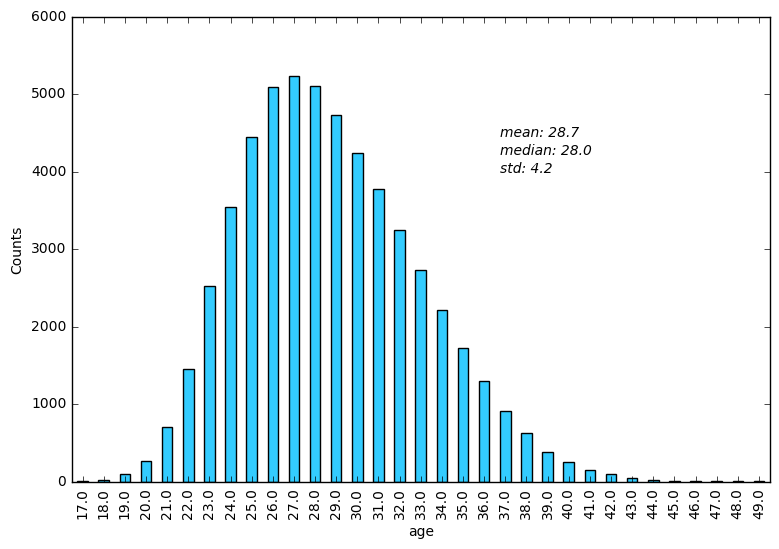

In [42]:
grouped_by_age = bat_age.groupby('age') 
players = grouped_by_age.playerID.count()
players.plot(kind = 'bar', figsize=(9,6), color = '#33ccff')
plt.ylabel('Counts')
mean_val = 'mean: ' + str(round(bat_age['age'].describe()[1], 1))
std_dev = 'std: ' + str(round(bat_age['age'].describe()[2], 1))
median = 'median: ' + str(round(bat_age['age'].describe()[5], 1))
plt.figtext(0.6, 0.7, mean_val, style='italic')
plt.figtext(0.6, 0.67, median, style='italic')
plt.figtext(0.6, 0.64, std_dev, style='italic')
print 'Figure 9. Distribution of ages in MLB'

A bell-shaped distribution of age with the mean at 28.7 (median at 28) and standard deviation of 4.2 is shown in figure 9. 

In [43]:
bat_age['age'].describe()

count    54928.000000
mean        28.745940
std          4.218964
min         17.000000
25%         26.000000
50%         28.000000
75%         31.000000
max         49.000000
Name: age, dtype: float64

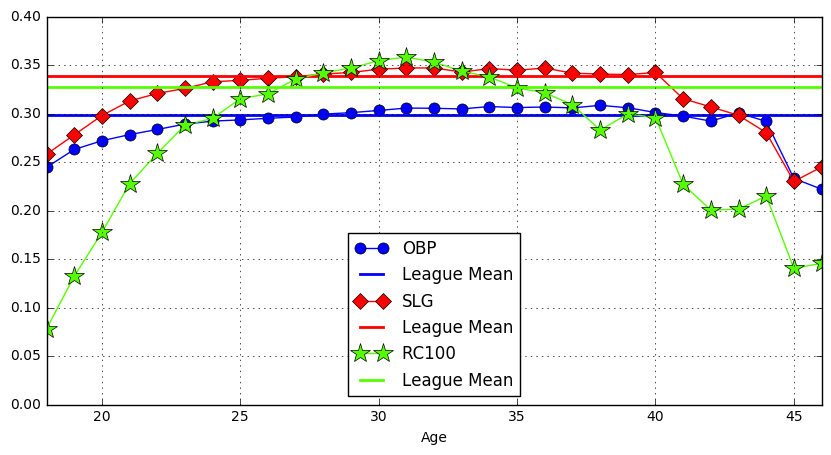

Figure 10. OBP, SLG, and RC100 dependence on age


In [44]:
plt.figure(figsize = (10,5))
obp_grouped = grouped_by_age['OBP'].mean()
slg_grouped= grouped_by_age['SLG'].mean()
rc100_grouped = grouped_by_age['RC100'].mean()

plt.plot(obp_grouped, color = 'b', label = 'OBP', marker='o', markersize= 8)
plt.plot([17, 48], [obp_league, obp_league], 'k-', lw= 2.0, c = 'b', label = 'League Mean')
plt.plot(slg_grouped, color = 'r', label = 'SLG', marker='D', markersize=8)
plt.plot([17, 48], [slg_league, slg_league], 'k-', lw=2.0, c = 'r', label = 'League Mean')
plt.plot(rc100_grouped, color = '#55ff00', label = 'RC100', marker='*', markersize= 15)
plt.plot([17, 48], [rc100_league, rc100_league], 'k-', lw= 2.0, c = '#55ff00', label = 'League Mean')

plt.legend(loc = 0)
plt.grid(True)

plt.xlim(18, 46)

plt.xlabel('Age')


plt.show()
print 'Figure 10. OBP, SLG, and RC100 dependence on age'

Figure 10 illustrates the dependence of  be  the three statistics on age. Mean SLG and mean OBP show a 'plateau' that extends almost from 25 up to 40 years old, they lie near the line for the league mean. These stats do not reflect the age distribution and do not provide a reason for retirement before 45, which is unrealistic.  
RC100 has a bell-shaped dependence that peaks in the early 30s and remains above the league mean up to the age of 35. Although this statistic has a behavior that allows us to determine optimum age intervals according to certain performance threshold, its maximum appears shifted from the peak of age distribution (which is a natural response to baseball driving laws). It also intersects the mean retirement age (34). 
Figure 11 depicts the evolution of mean retirement age, median of players' age and mean debut age by decades. Their behavior has been stable on time, showing small oscillations within 1-3 years range over more than a century.

In [45]:
bat_age02 = bat_age.copy()

bat_age02['debut']=pd.to_datetime(bat_age02['debut'], format="%Y/%m/%d")
bat_age02['finalGame'] = pd.to_datetime(bat_age02['finalGame'], format="%Y/%m/%d")

bat_age02['finalYear'] = bat_age02['finalGame'].dt.year
bat_age02['firstYear'] = bat_age02['debut'].dt.year

bat_age02['retAge'] = bat_age02['finalYear']-bat_age02['birthYear']
bat_age02['debAge'] = bat_age02['firstYear']-bat_age02['birthYear']

In [46]:
#There is no way to know who's retiring and who's comming back next year
bat_age02 = bat_age02[bat_age02['finalYear']< 2015]

Figure 11. Mean Retirement Age, Median age, and Mean Debut Age for each decade


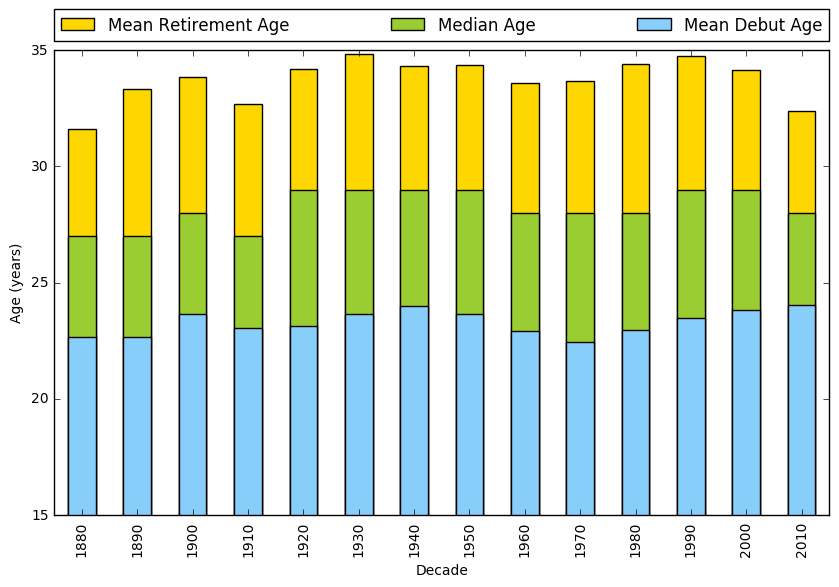

In [47]:
mean_by_dec03 = bat_age.groupby([(bat_age['yearID']//10)*10]).median()
mean_by_dec04 = bat_age02.groupby([(bat_age02['yearID']//10)*10]).mean()

plt.figure(figsize = (10,6))
mean_by_dec04['retAge'].plot(kind = 'bar', color = 'gold', label = 'Mean Retirement Age')
mean_by_dec03['age'].plot(kind = 'bar', color = 'yellowgreen', label = 'Median Age')
mean_by_dec04['debAge'].plot(kind = 'bar', color = 'lightskyblue', label = 'Mean Debut Age')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=3, mode="expand", borderaxespad=0.)
plt.ylim(15, 35)
plt.xlabel('Decade')
plt.ylabel('Age (years)')
print 'Figure 11. Mean Retirement Age, Median age, and Mean Debut Age for each decade'

In [48]:
bat_age02['retAge'].describe()

count    51307.000000
mean        33.955211
std          4.534588
min         19.000000
25%         31.000000
50%         34.000000
75%         37.000000
max         59.000000
Name: retAge, dtype: float64

In [49]:
bat_age02['debAge'].describe()

count    51307.000000
mean        23.293332
std          2.497414
min         16.000000
25%         22.000000
50%         23.000000
75%         25.000000
max         42.000000
Name: debAge, dtype: float64

# Conclusions

By searching on a baseball batting data, we were able to find correlations and regularities between some physical characteristics of baseball players and their batting performance.
Based on the statistics we used to measure batting performance (OBP, SLG, and RC100), we conclude that as an average, left-handed hitters perform better than the rest. 
Being a switch hitter does not seem to be the ultimate batting skill when it comes to more than a hundred years of batting statistics.  Their average performance lies above that of right-handed hitters but below the one corresponding to left-handed players.
The data also suggests that this gap in average performance has been narrowing in recent decades. 
There is no clear correlation between the offensive statistics and players' weight, but when the batting abilities of the players are not so far apart, the variability in weight could explain up to 64% of the change in mean slugging percentage.  Also, as an average, players in the uppermost weight quartile tend to have a superior performance in SLG and RC100 and the worst in OBP.
In the last three decades, the mean weight of baseball players has increased more that it did in the previous century.
The median of the baseball players age is 28 years, and it did not change much in more than a hundred years.  The mean age for retirement is 34 years, and it also has remained stable over time. 
OBP and SLG are not very useful as statistics when we search for optimum age intervals. RC100 does have a bell-shaped behavior with age that can be helpful as a predictor. However, it peaks at the age of 31, which is close to the mean age for retirement.


# References:

-  [1] Sabermetrics. (2016, October 28). In Wikipedia, The Free Encyclopedia. Retrieved 01:58, October 28, 2016, from https://en.wikipedia.org/w/index.php?title=Sabermetrics&oldid=746543151

- [2] Top Score. "RBIs are a really bad indicator" (04/25/2015). https://topscorebaseball.com/blog/rbis-are-a-really-bad-indicator/

- [3] J. Albert, Sabermetrics: The past, the present and the future. Chapter 1 in “Mathematics and Sports”. Joseph A. Gallian (Editor) The Mathematical Association of America. (2010)

- [4] Runs created. (2016, August 18). In Wikipedia, The Free Encyclopedia. Retrieved 14:05, August 18, 2016, from https://en.wikipedia.org/w/index.php?title=Runs_created&oldid=735082341

- [5] On-base percentage. (2016, September 17). In Wikipedia, The Free Encyclopedia. Retrieved 00:27, September 17, 2016, from https://en.wikipedia.org/w/index.php?title=On-base_percentage&oldid=739786072

- [6] John Walsh, "The advantage of batting left-handed". The Hardball Times Nov. 15, 2007 (http://www.hardballtimes.com/the-advantage-of-batting-left-handed/)